## Toy implementation of the [Implicit Geometric Regularization for Learning Shapes](https://arxiv.org/abs/2002.10099) paper

[Siren](https://vsitzmann.github.io/siren/)

[Rendering Worlds with Two Triangles](https://www.iquilezles.org/www/material/nvscene2008/rwwtt.pdf)

https://www.iquilezles.org/www/articles/distfunctions/distfunctions.htm

[NeRF](https://www.matthewtancik.com/nerf)

https://dellaert.github.io/NeRF/

In [23]:
from IPython.display import Image, HTML, clear_output

In [24]:
!pip install trimesh
clear_output() 

In [25]:
#@title Imports and Notebook Utilities
%tensorflow_version 2.x

import os
import sys
import io
import time
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import glob
import trimesh
import requests
import numpy as np
import matplotlib.pylab as pl

import tqdm

os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

In [27]:
import logging


class CustomHandler(logging.StreamHandler):
    def __init__(self):
        logging.StreamHandler.__init__(self)
        fmt = '%(asctime)s %(filename)-18s %(levelname)-8s: %(message)s'
        fmt_date = '%Y-%m-%d %H:%M:%S'
        formatter = logging.Formatter(fmt, fmt_date)
        self.setFormatter(formatter)


def get_logger():
    logger = logging.getLogger('root')
    logger.setLevel('INFO')
    logging.disable(logging.DEBUG)

    if logger.hasHandlers():
        logger.handlers.clear()
    logger.addHandler(CustomHandler())

    return logger

In [28]:
logger = get_logger()

Check GPU usage

In [29]:
# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)

tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a


def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img


def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)


def imread(url, max_size=None, mode=None):
  if url.startswith(('http:', 'https:')):
    r = requests.get(url)
    f = io.BytesIO(r.content)
  else:
    f = url
  img = PIL.Image.open(f)
  if max_size is not None:
    img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  if mode is not None:
    img = img.convert(mode)
  img = np.float32(img)/255.0
  return img


def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)


def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()


def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string


def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))


In [32]:
def dist_and_grad(sdf, points):
  with tf.GradientTape() as g:
    g.watch(points)
    dist = sdf(points)
  point_grad = g.gradient(dist, points)
  return dist, point_grad


def compute_loss(sdf, points, bg_point_n=500):
  n, dim = points.shape
  all_points = tf.concat([points, tf.random.uniform([bg_point_n, dim], -2.0, 2.0)], 0)
  dist, grad = dist_and_grad(sdf, all_points)
  surface_loss = tf.reduce_mean(tf.square(dist[:n]))
  offsurface_loss = tf.reduce_mean(tf.exp(-tf.square(dist[n:]/0.02)))
  grad_norm2 = tf.reduce_sum(tf.square(grad), -1)
  grad_loss = tf.reduce_mean(tf.square(grad_norm2-1.0))

  return surface_loss*1e2 + grad_loss + offsurface_loss

In [33]:
def vis_f(sdf, points=None, d=1.5):
  y, x = np.mgrid[-d:d:256j, -d:d:256j]
  coords = np.stack([x, y], -1).astype(np.float32)
  dist = sdf(coords)[...,0]
  f = pl.figure(figsize=(10, 8))
  pl.axis('equal')
  pl.grid()
  pl.contourf(x, y, dist, 16);
  pl.colorbar();
  pl.contour(x, y, dist, levels=[0.0], colors='white');

  if points is not None:
    dist, point_grad = dist_and_grad(sdf, points)
    x, y = points.numpy().T
    u, v = point_grad.numpy().T
    pl.quiver(x, y, u, v, color='white')

  pl.show()

## 3d

In [34]:
def init_model():
  return Sequential(
          [Activation(lambda x:x*50.0)] + 
          [Dense(80, tf.nn.swish) for i in range(6)] + 
          [Dense(1,
              kernel_initializer=tf.initializers.constant(1.0/80),
              bias_initializer=tf.initializers.constant(-0.1))]
        )


# for visualization
def sdf_slice(sdf, xy):
  return sdf(tf.concat([xy, xy[...,:1] * 0.0], -1))


@tf.function(experimental_compile=True)
def render(sdf, R, offset, fov=0.7, size=512):
  x = tf.linspace(-fov, fov, size)
  x, y = tf.meshgrid(x, -x)
  rays = tf.stack([x, y, -tf.ones_like(x)], -1)
  rays = tf.nn.l2_normalize(rays, -1) @ R
  pos0 = np.float32([[0, 0, 2.5]]) @ R
  pos = pos0+tf.zeros_like(rays)
  for i in tf.range(40):
    pos += rays*(sdf(pos)-offset)
  dist, normal = dist_and_grad(sdf, pos)

  return normal*0.5+0.5


def default_train_params():
  loss_log = []
  lr0 = 3e-3
  lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
      [3000, 6000, 8000], [lr0, lr0*0.3, lr0*0.1, lr0*0.03])
  trainer = tf.optimizers.Adam(lr)

  return loss_log, lr0, lr, trainer


In [35]:
def get_verts(mesh):
  verts = np.float32(mesh.vertices)
  verts -= verts.mean(0)
  verts /= verts.ptp()*0.4
  x, y, z = verts.T
  pl.axis('equal')
  pl.plot(x, y, '.', alpha=0.02)

  return verts


def train_model(verts, sdf, trainer, loss_log, n_iters = 40_000):

  @tf.function
  def train_step(sdf, trainer, points):
    with tf.GradientTape() as g:
      loss = compute_loss(sdf, points, 2500)
    params = g.watched_variables()
    grads = g.gradient(loss, params)
    trainer.apply_gradients(zip(grads, params))
    return loss

  iters_time = []
  for i in range(n_iters):
    points = verts[np.random.choice(len(verts), 3000, False)]
    start = time.time()
    loss = train_step(sdf, trainer, points)
    end = time.time()
    iters_time.append(end - start)
    loss_log.append(loss.numpy())
    if i > 100 and i % 10**int(np.log10(i+1)) == 0:
      clear_output(True)
      R = np.float32(trimesh.transformations.euler_matrix(0.5, 0.5, 0.0)[:3,:3])
      imshow(render(sdf, R, 0.0))
      pl.yscale('log')
      pl.plot(loss_log, '.', alpha=0.05);
      pl.show()
      print(len(loss_log), loss.numpy())

  return sdf, loss_log, iters_time


def compute_occupancy_f1(points, sdf, true_sdf_val):
  preds_np = sdf(points).numpy().flatten()
  results = np.sign(true_sdf_val) == np.sign(preds_np)
  return results.sum() / results.shape[0]


def test_sdf(sdf, obj_idx):
  points_near_surface = np.load(f'/content/drive/MyDrive/UCU/4course_1term/Computer_Vision/Practice/data/test_npy_meshes/points_near_surface_obj{obj_idx}.npy')
  sdf_val_near_surface = np.load(f'/content/drive/MyDrive/UCU/4course_1term/Computer_Vision/Practice/data/test_npy_meshes/sdf_val_near_surface_obj{obj_idx}.npy')
  points_random = np.load(f'/content/drive/MyDrive/UCU/4course_1term/Computer_Vision/Practice/data/test_npy_meshes/points_random_obj{obj_idx}.npy')
  sdf_val_random = np.load(f'/content/drive/MyDrive/UCU/4course_1term/Computer_Vision/Practice/data/test_npy_meshes/sdf_val_random_obj{obj_idx}.npy')

  f1_near_surface = compute_occupancy_f1(points_near_surface, sdf, sdf_val_near_surface)
  print('Occupancy F1 near surface: ', f1_near_surface)

  f1_random = compute_occupancy_f1(points_random, sdf, sdf_val_random)
  print('Occupancy F1 random: ', f1_random)

  return f1_near_surface, f1_random


In [36]:
from datetime import datetime


def test_one_obj(mesh, obj_idx):
  started_datetime = datetime.now()
  sdf = init_model()
  loss_log, lr0, lr, trainer = default_train_params()
  verts = get_verts(mesh)

  sdf, loss_log, iters_time = train_model(verts, sdf, trainer, loss_log, n_iters = 40_000)
  f1_near_surface, f1_random = test_sdf(sdf, obj_idx)
  avg_time_secs = sum(iters_time) / len(iters_time)
  memory_in_kb = round(sys.getsizeof(sdf) / 1024, 2)
  print('avg_time_secs: ', avg_time_secs)
  print('memory_in_kb: ', memory_in_kb)

  print(f'{started_datetime}: Started object processing')
  print(f'{datetime.now()}: Finished object processing')

  return {
        'f1_near_surface': f1_near_surface,
        'f1_random': f1_random,
        'avg_time_secs': avg_time_secs,
        'memory_usage': memory_in_kb
        } 


In [37]:
metrics_dct = {}

In [38]:
obj_idx = 0
mesh = trimesh.load(f'/content/drive/MyDrive/UCU/4course_1term/Computer_Vision/Practice/data/test_task_meshes/{obj_idx}.obj')
print('Ground truth:')
mesh.show()

Ground truth:


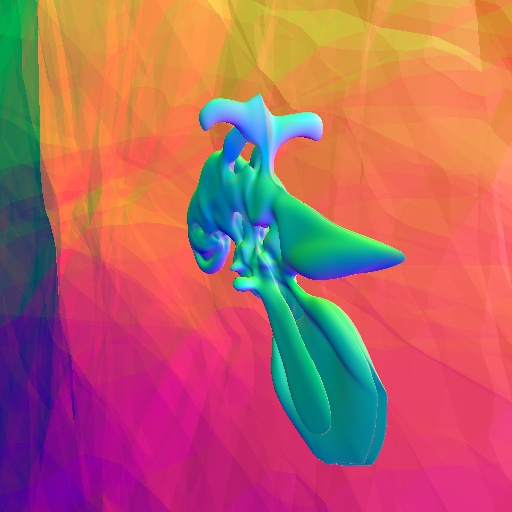

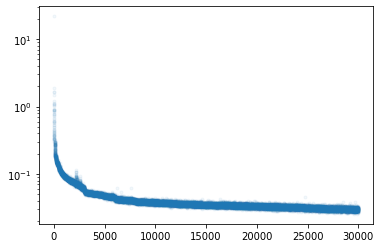

30001 0.029146694
Occupancy F1 near surface:  0.53112
Occupancy F1 random:  0.88574
avg_time_secs:  0.0046368815422058104
memory_in_kb:  0.05
2022-12-03 19:21:54.402334: Started object processing
2022-12-03 19:26:36.375027: Finished object processing


In [39]:
metrics_dct[f'obj_{obj_idx}'] = test_one_obj(mesh, obj_idx)

In [40]:
obj_idx = 1
mesh = trimesh.load(f'/content/drive/MyDrive/UCU/4course_1term/Computer_Vision/Practice/data/test_task_meshes/{obj_idx}.obj')
print('Ground truth:')
mesh.show()

Ground truth:


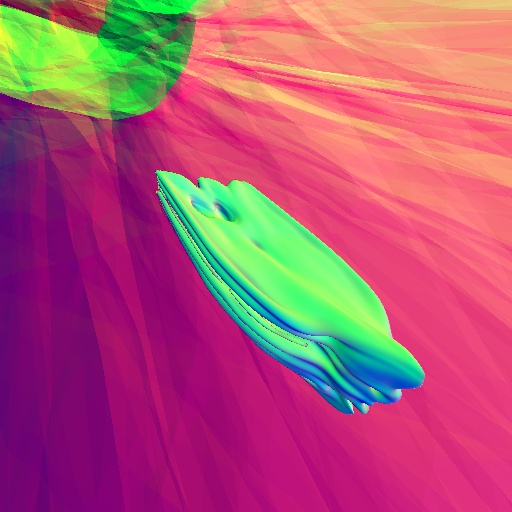

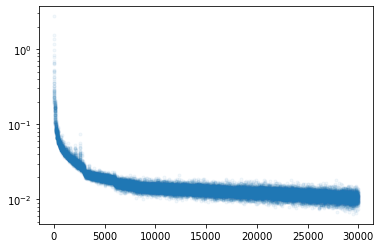

30001 0.011424021
Occupancy F1 near surface:  0.5135
Occupancy F1 random:  0.91324
avg_time_secs:  0.004388435214757919
memory_in_kb:  0.05
2022-12-03 19:26:36.781747: Started object processing
2022-12-03 19:30:56.818601: Finished object processing


In [41]:
metrics_dct[f'obj_{obj_idx}'] = test_one_obj(mesh, obj_idx)

In [42]:
obj_idx = 2
mesh = trimesh.load(f'/content/drive/MyDrive/UCU/4course_1term/Computer_Vision/Practice/data/test_task_meshes/{obj_idx}.obj')
print('Ground truth:')
mesh.show()

Ground truth:


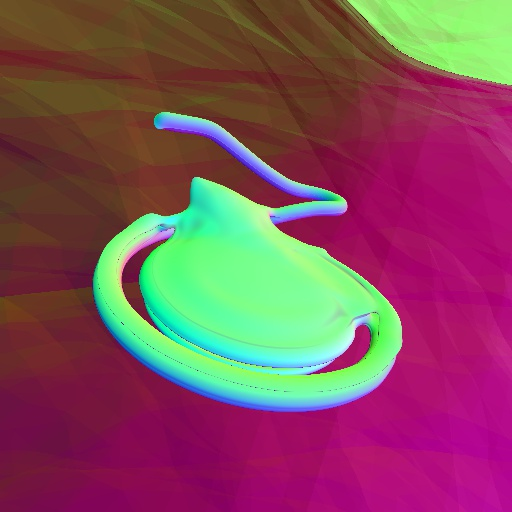

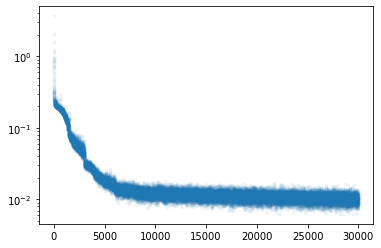

30001 0.011095449
Occupancy F1 near surface:  0.53504
Occupancy F1 random:  0.9119
avg_time_secs:  0.004428273767232895
memory_in_kb:  0.05
2022-12-03 19:30:57.271987: Started object processing
2022-12-03 19:35:27.774931: Finished object processing


In [43]:
metrics_dct[f'obj_{obj_idx}'] = test_one_obj(mesh, obj_idx)

In [44]:
obj_idx = 3
mesh = trimesh.load(f'/content/drive/MyDrive/UCU/4course_1term/Computer_Vision/Practice/data/test_task_meshes/{obj_idx}.obj')
print('Ground truth:')
mesh.show()

Ground truth:


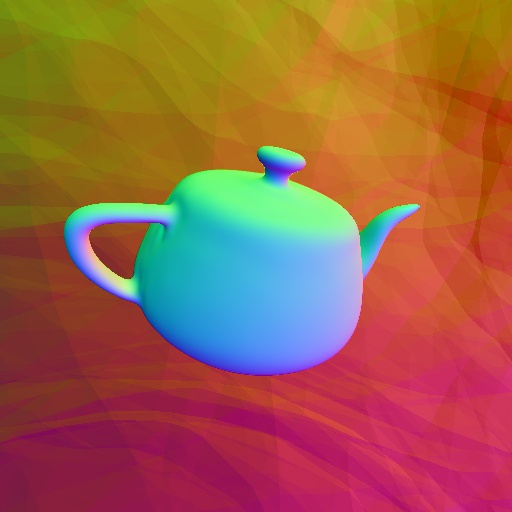

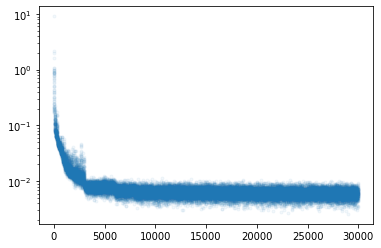

30001 0.0073115556
Occupancy F1 near surface:  0.50412
Occupancy F1 random:  0.80038
avg_time_secs:  0.004445396882295609
memory_in_kb:  0.05
2022-12-03 19:35:28.295677: Started object processing
2022-12-03 19:40:04.843555: Finished object processing


In [45]:
metrics_dct[f'obj_{obj_idx}'] = test_one_obj(mesh, obj_idx)

In [53]:
obj_idx = 5
mesh = trimesh.load(f'/content/drive/MyDrive/UCU/4course_1term/Computer_Vision/Practice/data/test_task_meshes/{obj_idx}.obj')
print('Ground truth:')
mesh.show()

Ground truth:


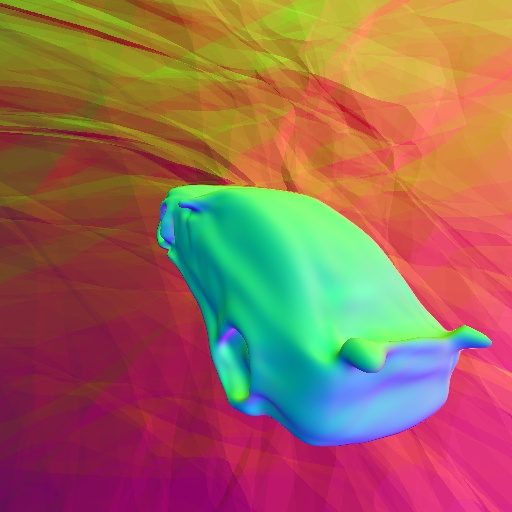

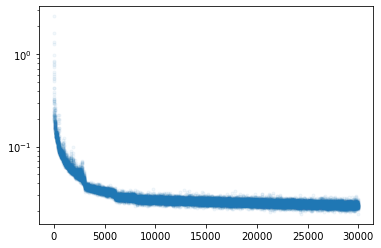

30001 0.022495328
Occupancy F1 near surface:  0.51892
Occupancy F1 random:  0.86272
avg_time_secs:  0.004284402298927307
memory_in_kb:  0.05
2022-12-03 20:08:53.821255: Started object processing
2022-12-03 20:13:17.708406: Finished object processing


In [54]:
metrics_dct[f'obj_{obj_idx}'] = test_one_obj(mesh, obj_idx)

### Average metrics

In [55]:
iter_times = []
model_memory_sizes = []
f1_near_surface_vals = []
f1_random_vals = []

for obj_idx in metrics_dct.keys():
  obj_metrics = metrics_dct[obj_idx]

  f1_near_surface_vals.append(obj_metrics['f1_near_surface'])
  f1_random_vals.append(obj_metrics['f1_random'])
  iter_times.append(obj_metrics['avg_time_secs'])
  model_memory_sizes.append(obj_metrics['memory_usage'])

In [56]:
def print_lst_avg(title, lst):
  print(f'Average {title} based {len(lst)} objects: ', round(sum(lst) / len(lst), 4))

print_lst_avg('iteration time (in seconds)', iter_times)
print_lst_avg('memory usage (in Kb)', model_memory_sizes)
print_lst_avg('occupancy F1 random', f1_random_vals)
print_lst_avg('occupancy F1 near surface', f1_near_surface_vals)

Average iteration time (in seconds) based 5 objects:  0.0044
Average memory usage (in Kb) based 5 objects:  0.05
Average occupancy F1 random based 5 objects:  0.8748
Average occupancy F1 near surface based 5 objects:  0.5205


In [57]:
import json

with open('/content/drive/MyDrive/UCU/4course_1term/Computer_Vision/Practice/data/results/SRN_metrics.json', 'w') as fp:
    json.dump(metrics_dct, fp)